In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import StringType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import wordcloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from pyspark.sql. functions import length, col, avg, count, when
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [0]:
import time

start_spark = time.time()
df_spark = spark.table("workspace.default.train_1")

df_spark.write.format("noop").mode("overwrite").save() 

spark_time = time.time() - start_spark

start_pandas = time.time()
df_pandas = df_spark.toPandas()
pandas_time = time.time() - start_pandas

print(f"Spark Processing Time (Noop/Count): {spark_time:.2f} seconds")
print(f"Time to Collect to Pandas (Overhead): {pandas_time:.2f} seconds")

Spark Processing Time (Noop/Count): 15.08 seconds
Time to Collect to Pandas (Overhead): 17.59 seconds


In [0]:
df = spark.table("workspace.default.train_1")

# EDA (Exploratory Data Analysis)

Total record Data

In [0]:
total_records = df.count()
print(f"Total Records: {total_records: ,}")

Total Records:  3,599,999


In [0]:
print("Data Schema:")
df.printSchema()

Data Schema:
root
 |-- class: long (nullable = true)
 |-- title: string (nullable = true)
 |-- review: string (nullable = true)



In [0]:
print("Sample Data (5 Baris Awal):")
display(df.limit(5))

Sample Data (5 Baris Awal):


class,title,review
1,It IS Bitter...,"It is bitter. After spraying it, even very sparingly, the smell and taste hung in the air, permeating... everything.Our puppy wasn't a fan of it. For about... five seconds. And then he ignored it. I gave it two stars because it's bitter, and because it might be that our dog is just impervious... but it didn't work."
1,This product did not work at all!,"We purchased this product so that our cat would not continue licking some spots on her fur. We sprayed quite a bit just to be sure that it would work. Within a matter of a half hour, so licked it all off, and it did not deter her whatsoever. I would not recommend this product."
1,I expect more for this price.,"Pros:-Pockets for everything - file dividers, padded laptop pocket, pens, business cards, keys, etc.-Expandable for use as overnight or carry-on bag.-Beautiful, professional looking leather.Cons:-Wimpy - The leather on this is more like a fancy purse than a briefcase; it's too sensitive to abrasion. I got a small rip in it the first week catching it on an office chair.-Bulky - Even if you carry more than average to/from the office, this bag is too bulky. The padding and several pockets and dividers add too much space.-No bottom reinforcement - For a bag that can hold so much and be used as a carry-on, it needs extra protection on the bottom for setting on the ground. I'm afraid to set this on pavement because of the sensitive leather."
2,Must read for parents and educators,"Dr. Hallowell is an amazing fellow. He strikes the perfect balance between being a knowledgeable psychiatrist and a vulnerable, loving and warm father. Whether you are an educator or a parent, you will learn much, reminiscence and have a chance to be a better person after reading this book. The Childhood Roots gives you good laughs and concrete tips to enjoy children and strengthen the foundation for life. Better yet, it gives you a map and the needed information to know whether you're still on the road or lost in your way. If there is one book to read when becoming a parent and realizing what your job is, this is it."
2,A CHILD PSYCHIATRIST WHO TRULY KNOWS &LOVES CHILDREN,"IN THIS DAY AND AGE, WE ALL NEED REGROUNDING - WE LIVE IN A TROUBLED TIME AND BRINGING UP CHILDREN IS OUR MOST IMPORTANT JOB.BUT....WE HAVE NO TRAINING - WE LEARN ON THE JOB - WE MAKE MISTAKES - WE HAVE SUCCESS AND NOW WE HAVE DR. HALLOWELL TO HELP US NAVIGATE.AS ONE OF THE MANY SINGLE MOMS, I THANK YOU FOR THIS WONDERFUL BOOK FILLED WITH INSIGHT AND THOUGHTFUL GUIDENCE. I WILL PASS A COPY ALONG TO MY CHILDREN WHEN THE TIME COMES.NANCY OGDENPRODUCER, Attention Deficit Disorder in the 21st Century,A Conversation with Edward M. HallowellA video series for parents, kids & Teachers"


Cek Missing Value

In [0]:
print("\Missing Values Check:")
from pyspark.sql.functions import col, sum as spark_sum, isnan, when, count as spark_count

missing_check = df.select([
    spark_count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).toPandas()

print(missing_check. T.rename(columns={0: 'Missing Count'}))

\Missing Values Check:
        Missing Count
class               0
title              48
review              0


In [0]:
df = df.na.drop()

In [0]:
print("\Missing Values sekarang:")
from pyspark.sql.functions import col, sum as spark_sum, isnan, when, count as spark_count

missing_check = df.select([
    spark_count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).toPandas()

print(missing_check. T.rename(columns={0: 'Missing Count'}))

\Missing Values sekarang:
        Missing Count
class               0
title               0
review              0


cek duplicade

In [0]:
duplicate_count = df.count() - df.dropDuplicates(['review']).count()
print(f"\n Duplicate Reviews: {duplicate_count:,}")


 Duplicate Reviews: 5,217


In [0]:
df = df.dropDuplicates(['review'])

In [0]:
duplicate_count = df.count() - df.dropDuplicates(['review']).count()
print(f"\n Duplicate Reviews: {duplicate_count:,}")


 Duplicate Reviews: 0


In [0]:
total_records = df.count()
print(f"Total Records now(after drop duplicate): {total_records: ,}")

Total Records now(after drop duplicate):  3,594,734



Distribusi Kelas:
   class    count
0      1  1796130
1      2  1798604

Persentase Distribusi:
   Negatif:   1,796,130.0 (49.97%)
   Positif:   1,798,604.0 (50.03%)


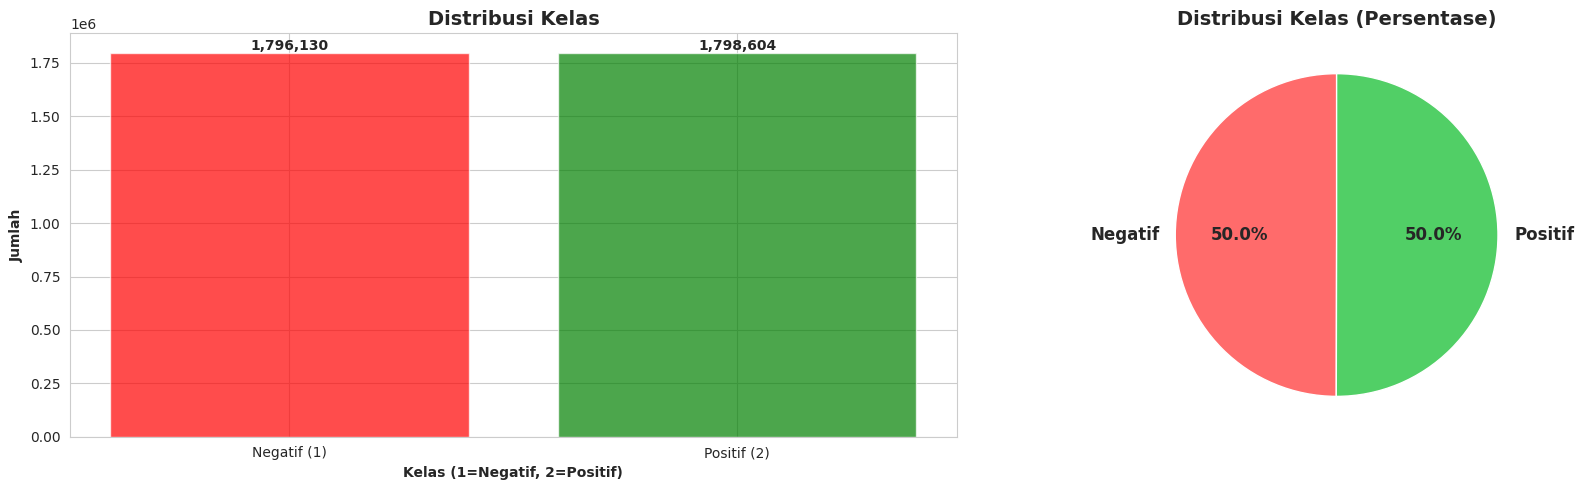

In [0]:
class_dist = df.groupBy("class").count().orderBy("class").toPandas()

print("\nDistribusi Kelas:")
print(class_dist)

class_dist['percentage'] = (class_dist['count'] / class_dist['count'].sum() * 100).round(2)
print("\nPersentase Distribusi:")
for idx, row in class_dist.iterrows():
    label = "Negatif" if row['class'] == 1 else "Positif"
    print(f"   {label}:  {row['count']: ,} ({row['percentage']}%)")

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].bar(class_dist['class'], class_dist['count'], color=['red', 'green'], alpha=0.7)
axes[0].set_xlabel('Kelas (1=Negatif, 2=Positif)', fontweight='bold')
axes[0].set_ylabel('Jumlah', fontweight='bold')
axes[0].set_title('Distribusi Kelas', fontweight='bold', fontsize=14)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Negatif (1)', 'Positif (2)'])
for i, v in enumerate(class_dist['count']):
    axes[0].text(class_dist['class']. iloc[i], v, f'{v:,}', ha='center', va='bottom', fontweight='bold')


colors = ['#ff6b6b', '#51cf66']
axes[1].pie(class_dist['count'], labels=['Negatif', 'Positif'], autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize':  12, 'fontweight':  'bold'})
axes[1].set_title('Distribusi Kelas (Persentase)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

Dari hal tersebut Labelnya balance


Rata-rata Statistik Teks Berdasarkan Kelas:
class_label  avg_char_length  avg_word_count
    Negatif       420.763052       77.127033
    Positif       389.467329       71.204843

Statistik Teks Keseluruhan:
   Panjang Karakter - Rata-rata: 404.83, Median: 355.00
   Jumlah Kata      - Rata-rata: 74.11, Median: 65.00


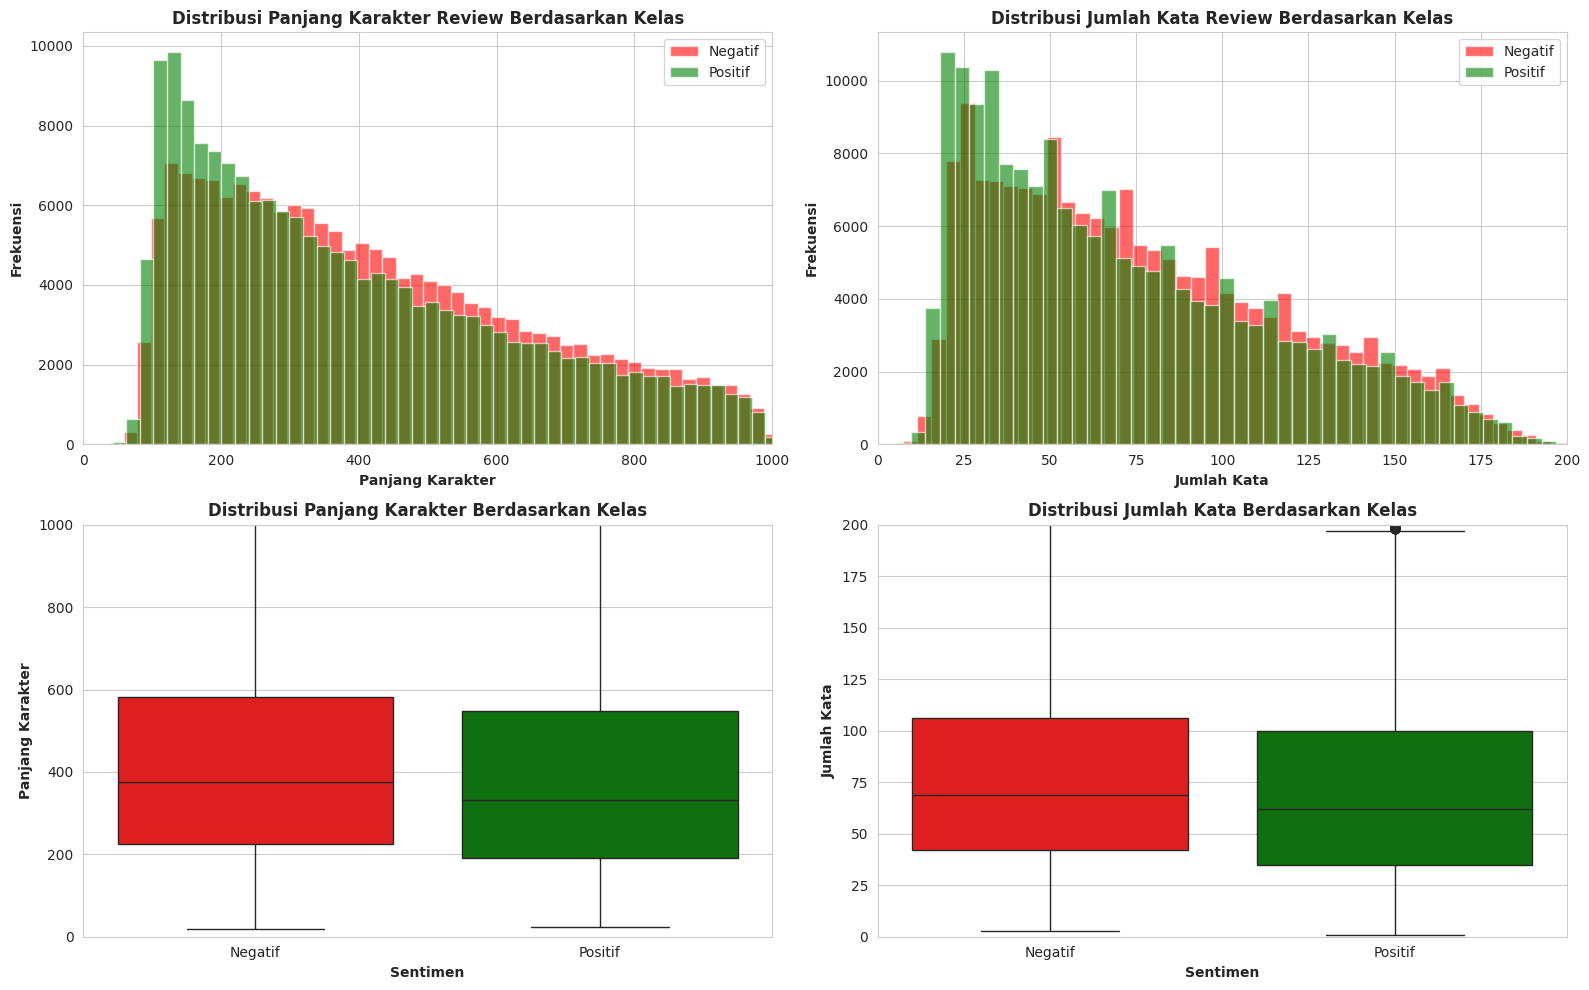

In [0]:
from pyspark.sql. functions import regexp_replace


df_with_length = df.withColumn("review_length", length(col("review"))) \
                   .withColumn("word_count", length(col("review")) - length(regexp_replace(col("review"), " ", "")) + 1)


length_stats = df_with_length. groupBy("class").agg(
    avg("review_length").alias("avg_char_length"),
    avg("word_count").alias("avg_word_count")
).orderBy("class").toPandas()

print("\nRata-rata Statistik Teks Berdasarkan Kelas:")
length_stats['class_label'] = ['Negatif', 'Positif']
print(length_stats[['class_label', 'avg_char_length', 'avg_word_count']].to_string(index=False))


length_sample = df_with_length. select("class", "review_length", "word_count").sample(False, 0.1).toPandas()


print("\nStatistik Teks Keseluruhan:")
print(f"   Panjang Karakter - Rata-rata: {length_sample['review_length'].mean():.2f}, Median: {length_sample['review_length'].median():.2f}")
print(f"   Jumlah Kata      - Rata-rata: {length_sample['word_count'].mean():.2f}, Median: {length_sample['word_count'].median():.2f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribusi panjang karakter berdasarkan kelas
for class_val in [1, 2]: 
    data = length_sample[length_sample['class'] == class_val]['review_length']
    label = "Negatif" if class_val == 1 else "Positif"
    color = 'red' if class_val == 1 else 'green'
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=label, color=color)
axes[0, 0].set_xlabel('Panjang Karakter', fontweight='bold')
axes[0, 0].set_ylabel('Frekuensi', fontweight='bold')
axes[0, 0].set_title('Distribusi Panjang Karakter Review Berdasarkan Kelas', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 1000)

# Distribusi jumlah kata berdasarkan kelas
for class_val in [1, 2]:
    data = length_sample[length_sample['class'] == class_val]['word_count']
    label = "Negatif" if class_val == 1 else "Positif"
    color = 'red' if class_val == 1 else 'green'
    axes[0, 1].hist(data, bins=50, alpha=0.6, label=label, color=color)
axes[0, 1].set_xlabel('Jumlah Kata', fontweight='bold')
axes[0, 1]. set_ylabel('Frekuensi', fontweight='bold')
axes[0, 1]. set_title('Distribusi Jumlah Kata Review Berdasarkan Kelas', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 200)

# Box plot - Panjang karakter
length_sample['class_label'] = length_sample['class']. map({1: 'Negatif', 2: 'Positif'})
sns.boxplot(x='class_label', y='review_length', data=length_sample, ax=axes[1, 0], palette=['red', 'green'])
axes[1, 0].set_xlabel('Sentimen', fontweight='bold')
axes[1, 0].set_ylabel('Panjang Karakter', fontweight='bold')
axes[1, 0]. set_title('Distribusi Panjang Karakter Berdasarkan Kelas', fontweight='bold', fontsize=12)
axes[1, 0].set_ylim(0, 1000)

# Box plot - Jumlah kata
sns.boxplot(x='class_label', y='word_count', data=length_sample, ax=axes[1, 1], palette=['red', 'green'])
axes[1, 1].set_xlabel('Sentimen', fontweight='bold')
axes[1, 1].set_ylabel('Jumlah Kata', fontweight='bold')
axes[1, 1].set_title('Distribusi Jumlah Kata Berdasarkan Kelas', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

pada label negatif, review yang dilakukan lebih panjang

Median review negatif (garis tengah di boxplot merah) sedikit lebih tinggi dari review positif
Variasi panjang review negatif lebih besar (boxplot merah lebih tinggi), artinya review negatif lebih bervariasi ada yang sangat singkat, ada yang sangat detail
Review positif cenderung lebih konsisten panjangnya (boxplot hijau lebih pendek)

In [0]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def pra_proses(text):
    text = str(text).lower()  # casefolding
    text = re.sub(r"[^a-z\s]", "", text) 
    tokens = text.split()  # tokenization
    tokens = [w for w in tokens if w not in stop_words]  
    tokens = [stemmer.stem(w) for w in tokens]  
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/spark-
[nltk_data]     ae40dbc5-30a2-432f-91e4-4d/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /home/spark-
[nltk_data]     ae40dbc5-30a2-432f-91e4-4d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Menerapkan fungsi Praprosess, yng melakukan lowercase, menghapus punctuasi, melakukan split menghasilkan tokens,
menghapus stop word jika berada di tokens, menghapus bahasa slang,dilakukan juga stemming di tokens, lalu setelahnya di satukan lagi dengan join 

In [0]:
pra_proses_udf = udf(
    pra_proses,
    StringType()
)

df = df.withColumn(
    "review",
    pra_proses_udf(col("review"))
).withColumn(
    "class",
    when(col("class") == 1, 0).otherwise(1)
)
df_clean = df.select("review", "class")
display(df_clean.limit(5))

review,class
ive use ware famili raid control mani time one ive success linux kernel automat recogn plugplay need compil tweak driver etc want use linux want raid work highli recommend famili control cheap get pay,1
realli like radio problem found belt case flimsi would expect better oregon scientif,1
got dad presid colleg around christma eat parti hous month said stay fresh delici entir time huge bag trail mix,1
sever ant infest kitchen make sweet pickl thing anyway bought product along sever other gave good chanc test variou product product didnt attract ant well compar product also becam useless dri took hour side side comparison product combat ant kill gel raid ant gel terro liquid ant killer other terro product attract ant last much longer fyi consum associ manufactur retail sell product,0
old man short beauti poignant stori cri one point sentiment love stori fact love stori dont misl simpl move stori life set amazon felt much like hemingway old man sea feel direct simplic combin profound truth sepulveda much tune contemporari sensit peopl would find hemingway although love hemingway stori major theme old man read love stori destruct amazon say stori sort polit correct pablum much profound think hemingway would approv gusto,1



Jumlah sampel review negatif: 89,624
Jumlah sampel review positif: 89,756

Panjang teks review negatif:  21,028,889 karakter
Panjang teks review positif: 19,736,632 karakter


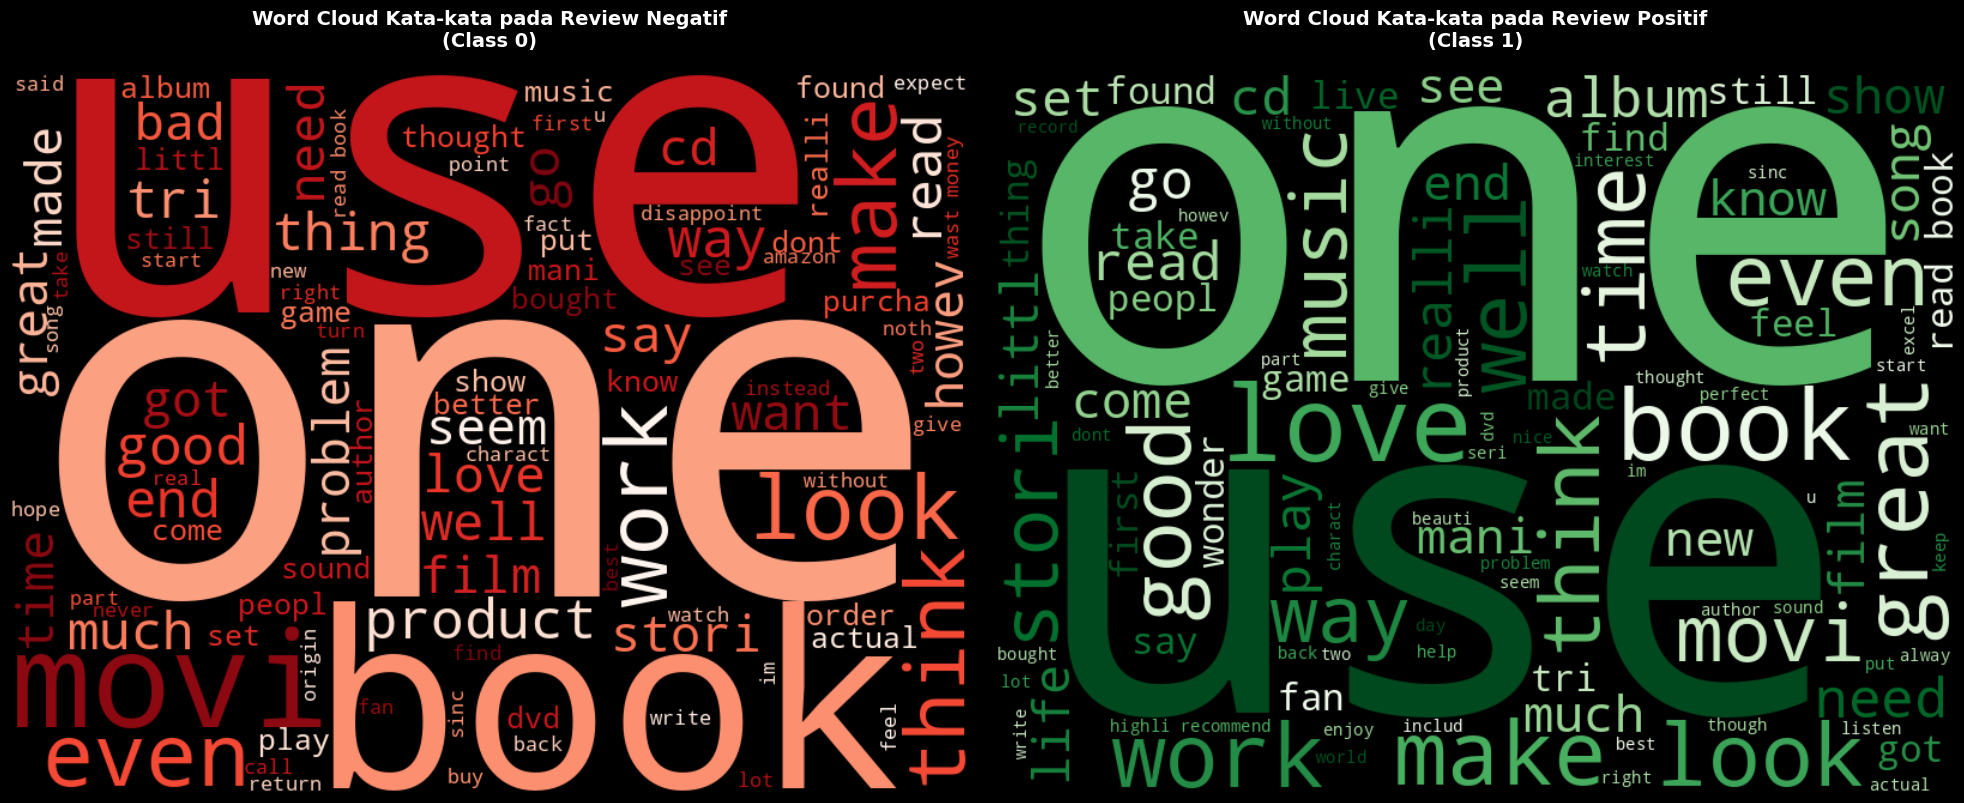


Word Cloud berhasil dibuat untuk review negatif dan positif
Sampel yang digunakan: 89,624 review negatif dan 89,756 review positif


In [0]:
negative_sample = df.filter(col("class") == 0).sample(False, 0.05, seed=42).toPandas()
positive_sample = df.filter(col("class") == 1).sample(False, 0.05, seed=42).toPandas()

print(f"\nJumlah sampel review negatif: {len(negative_sample):,}")
print(f"Jumlah sampel review positif: {len(positive_sample):,}")

negative_reviews = negative_sample['review']
positive_reviews = positive_sample['review']

list_words_negative = ' '.join(negative_reviews. astype(str).tolist())
list_words_positive = ' '.join(positive_reviews.astype(str).tolist())

print(f"\nPanjang teks review negatif:  {len(list_words_negative):,} karakter")
print(f"Panjang teks review positif: {len(list_words_positive):,} karakter")


fig, ax = plt.subplots(1, 2, figsize=(20, 8))


wordcloud_negative = WordCloud(
    width=800, 
    height=600, 
    background_color='black', 
    colormap='Reds',
    min_font_size=10,
    max_words=100,
    relative_scaling=0.5
).generate(list_words_negative)

ax[0].set_title('Word Cloud Kata-kata pada Review Negatif\n(Class 0)', 
                fontsize=14, fontweight='bold', color='white', pad=20)
ax[0].grid(False)
ax[0].imshow(wordcloud_negative, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_facecolor('black')


wordcloud_positive = WordCloud(
    width=800, 
    height=600, 
    background_color='black', 
    colormap='Greens',
    min_font_size=10,
    max_words=100,
    relative_scaling=0.5
).generate(list_words_positive)

ax[1].set_title('Word Cloud Kata-kata pada Review Positif\n(Class 1)', 
                fontsize=14, fontweight='bold', color='white', pad=20)
ax[1].grid(False)
ax[1].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_facecolor('black')

fig.patch.set_facecolor('black')
fig.tight_layout(pad=2)
plt.show()

print("\nWord Cloud berhasil dibuat untuk review negatif dan positif")
print(f"Sampel yang digunakan: {len(negative_sample):,} review negatif dan {len(positive_sample):,} review positif")

In [0]:
train_data, val_data, test_data = df_clean.randomSplit([0.7, 0.2, 0.1], seed=42)

In [0]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

idf = IDF(inputCol="rawFeatures", outputCol="features")

Linear Regresi

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="class")

In [0]:
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

In [0]:
model_pipeline = pipeline.fit(train_data)

In [0]:
binary_eval = BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderROC")
multi_eval = MulticlassClassificationEvaluator(labelCol="class", metricName="accuracy")


In [0]:

print("--- HASIL EVALUASI Linear Regression---")

val_predictions = model_pipeline.transform(val_data)
val_auc = binary_eval.evaluate(val_predictions)
val_acc = multi_eval.evaluate(val_predictions)
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation Acc: {val_acc:.4f}")

test_predictions = model_pipeline.transform(test_data)
test_auc = binary_eval.evaluate(test_predictions)
test_acc = multi_eval.evaluate(test_predictions)
print(f"Test AUC      : {test_auc:.4f}")
print(f"Test Acc      : {test_acc:.4f}")

--- HASIL EVALUASI Linear Regression---
Validation AUC: 0.9217
Validation Acc: 0.8488
Test AUC      : 0.9218
Test Acc      : 0.8485


Random Forest

In [0]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:

rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="class",
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline_rf = Pipeline(stages=[tokenizer, hashingTF, idf, rf])
model_pipeline_rf = pipeline_rf. fit(train_data)

In [0]:

print("\n=== RANDOM FOREST CLASSIFIER RESULTS ===")

val_predictions_rf = model_pipeline_rf.transform(val_data)
val_auc_rf = binary_eval.evaluate(val_predictions_rf)
val_acc_rf = multi_eval. evaluate(val_predictions_rf)
print(f"Validation AUC: {val_auc_rf:.4f}")
print(f"Validation Acc: {val_acc_rf:.4f}")

test_predictions_rf = model_pipeline_rf.transform(test_data)
test_auc_rf = binary_eval.evaluate(test_predictions_rf)
test_acc_rf = multi_eval.evaluate(test_predictions_rf)
print(f"Test AUC      :  {test_auc_rf:.4f}")
print(f"Test Acc      : {test_acc_rf:.4f}")


=== RANDOM FOREST CLASSIFIER RESULTS ===
Validation AUC: 0.8687
Validation Acc: 0.7808


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-7591852794607088>, line 12
     10 test_auc_rf = binary_eval.evaluate(test_predictions_rf)
     11 test_acc_rf = multi_eval.evaluate(test_predictions_rf)
---> 12 print(f"Test AUC      :  {test_auc_rf:. 4f}")
     13 print(f"Test Acc      : {test_acc_rf:.4f}")

ValueError: Format specifier missing precision

In [0]:
print(f"Test AUC      :  {test_auc_rf:.4f}")
print(f"Test Acc      : {test_acc_rf:.4f}")

Test AUC      :  0.8693
Test Acc      : 0.7810



=== MODEL COMPARISON ===
              Model  Val AUC  Val Acc  Test AUC  Test Acc
Logistic Regression 0.921900 0.849200  0.922900  0.849900
      Random Forest 0.868707 0.780844  0.869314  0.781008


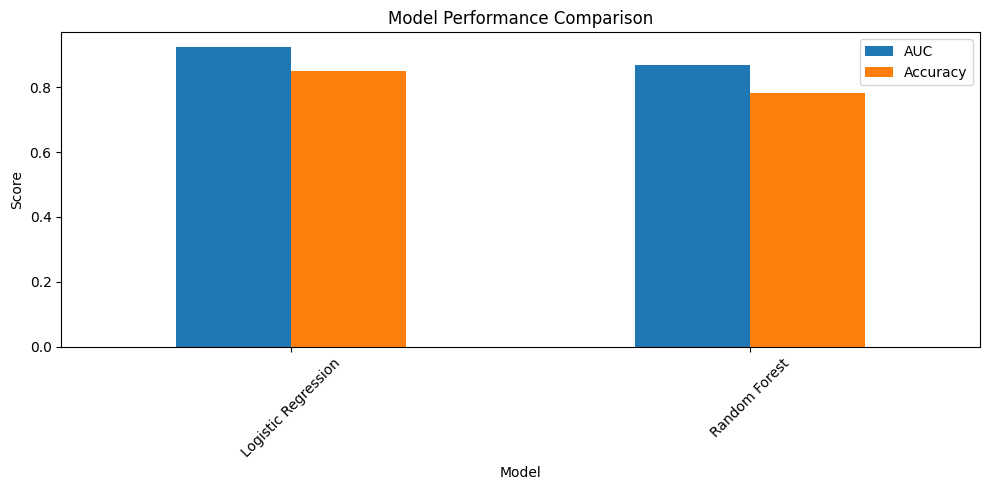

In [0]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Val AUC': [0.9219, val_auc_rf],
    'Val Acc': [0.8492, val_acc_rf],
    'Test AUC': [0.9229, test_auc_rf],
    'Test Acc': [0.8499, test_acc_rf]
})

print("\n=== MODEL COMPARISON ===")
print(comparison_df. to_string(index=False))

# Visualisasi
comparison_df.set_index('Model')[['Test AUC', 'Test Acc']].plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt. xticks(rotation=45)
plt.legend(['AUC', 'Accuracy'])
plt.tight_layout()
plt.show()

menggunakan model baselinee dengan linear reggression lebih baik dari pada random forest